In [7]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import normaltest
from scipy.stats import kendalltau
from scipy.stats import ttest_ind

# read in CSV file all_data as le_df (life expectancy data file)
le_df =  pd.read_csv("all_data.csv")
# brief inspection of data (commented after inspection)
# print(le_df.head(10))

# rename column
le_df.rename(columns = {'Life expectancy at birth (years)': 'Life_Exp'}, inplace = True)

# convert GDP into trillions of dollars
le_df['GDP in trillions'] = ['${:.3f}'.format(x/10**12) for x in le_df['GDP']]

#style for use when style req
df_format = {'Year':'{:.0f}', 'Life_Exp':"{:.1f}", 'GDP':"{:.3e}"}
df_hidden_col = ['GDP']
df_width = '120px'

# set table width
pd.options.display.width = 1000

# Print table
display(le_df.head(40).style
        .format(df_format)
        .hide_columns(df_hidden_col)
        .set_properties(width=df_width))

,Country,Year,Life_Exp,GDP in trillions
0,Chile,2000,77.3,$0.078
1,Chile,2001,77.3,$0.071
2,Chile,2002,77.8,$0.070
3,Chile,2003,77.9,$0.076
4,Chile,2004,78.0,$0.099
5,Chile,2005,78.4,$0.123
6,Chile,2006,78.9,$0.155
7,Chile,2007,78.9,$0.174
8,Chile,2008,79.6,$0.180
9,Chile,2009,79.3,$0.172


In [ ]:
# The initial scan of the first 10 rows showed only Chile. Scanning further rows, 
# we find that there are several countries. Reset the display to see the number of countries and years
# Further, we will look at some of the statistics, such as the number of rows, the Mean, 
# Standard Deviation, as well as the Five Number Summary

In [8]:
# Different Countries
display(le_df.Country.value_counts().to_frame().style
       .set_caption('Different Countries')
       .set_properties(width=df_width))

# use pandas to describe then convert GDP to billions

le_df_stats = le_df.describe()
le_df_stats['GDP in trillions'] = ['${:.3f}'.format(x/10**12) for x in le_df_stats['GDP']]
# adjust count to integer for 'GDP in trillions'
le_df_stats.loc['count', 'GDP in trillions'] = int(le_df_stats.loc['count', 'GDP'])
# display stats
display(le_df_stats.style
        .format(df_format)
        .hide_columns(df_hidden_col)
        .set_caption('Describing Statistical Values')
        .set_properties(width=df_width))


,Country
Chile,16
China,16
Germany,16
Mexico,16
United States of America,16
Zimbabwe,16


,Year,Life_Exp,GDP in trillions
count,96,96.0,96
mean,2008,72.8,$3.880
std,5,10.7,$5.198
min,2000,44.3,$0.004
25%,2004,74.5,$0.173
50%,2008,76.8,$1.280
75%,2011,78.9,$4.068
max,2015,81.0,$18.100


In [ ]:
# Now we can look to see if the data is normal by creating a pairplot

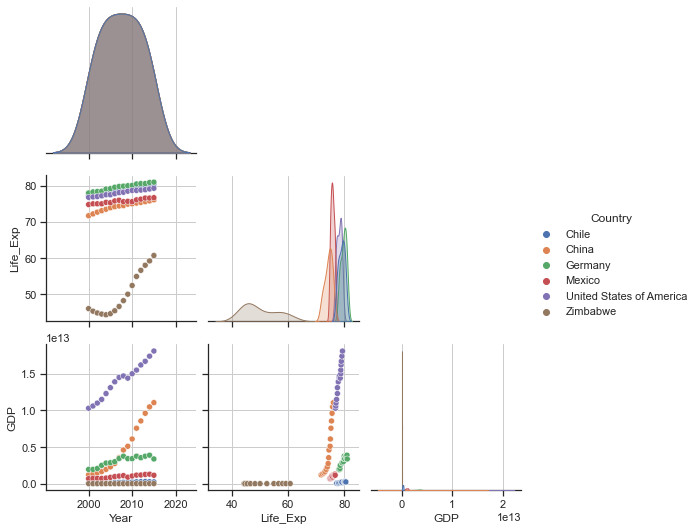

In [24]:
# themes

sns.set_theme(style = 'ticks', rc = {'axes.grid': True})

# Pairplot

sns.pairplot(le_df, hue = 'Country', corner = True)
plt.show()

In [ ]:
# Zimbabwe has data that lies far from the remainder of the other countries
# upon further investigation, the WHO shows that Zimbabwe had the lowest GDP and Life Expectancy in the world during this period
# Compounding this data is the fact that Zimbabwe had a significant drop in life expectancy during the 
# dates (2000 - 2015) for this data, due to a civil war during this time period
# The civil war in Zimbabwe greatly skews the entire data set making it difficult to understand
# so, we will create another pairplot omitting Zimbabwe to better determine if there is an actual correlation between GDP and 
# life expectancy for the other countries

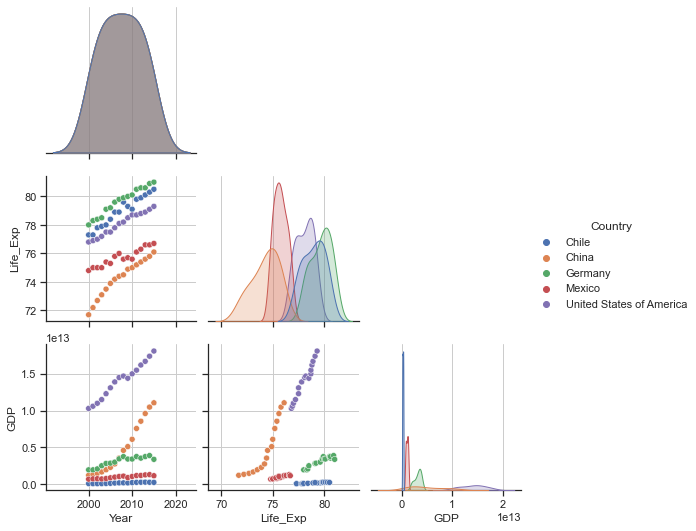

In [25]:
# Pairplot without Zimbabwe
sns.pairplot(le_df[le_df.Country != 'Zimbabwe'], hue='Country', corner=True)
plt.show()

In [ ]:
# After omitting Zimbabwe, we can see some better results from the pairplot. 
# In the plot with Life Expectancy vs. GDP, we can see some correlation, but it is not 
# conclusive, so a specific check for normality is in order

In [26]:
# Normality test - checking for correlation between GDP and Life Expectancy
_, p_val_GDP = normaltest(le_df.GDP)
_, p_val_Exp = normaltest(le_df.Life_Exp)

Norm_Test = pd.DataFrame({'p_value': [p_val_GDP, p_val_Exp]},index=['GDP', 'Life Expectation'])
alfa = 0.05
Norm_Test['Normality'] = Norm_Test.p_value.apply(lambda x: 'Rejected' if x<alfa else 'Accepted')

display(Norm_Test.style
        .set_caption('Normality test with confidence @ 95%')
        .set_properties(width=df_width))

,p_value,Normality
GDP,0.000007,Rejected
Life Expectation,0.000000,Rejected


In [ ]:
# Each p-value verifies that both GDP and Life Expectancy are non-normal distributions
# Evaluating a Kendall Tau may prove useful

In [13]:
# Kendall Tau
corr, p_val = kendalltau(le_df.GDP, le_df.Life_Exp)
print(f'KENDALL TAU: {corr:.5f}\np-value: {p_val:.5e}')

KENDALL TAU: 0.37042
p-value: 9.92493e-08


In [9]:
# The Kendall Tau evaluation shows a moderate correlation between GDP and Life Expectancy
# a Tau value near 1 is a strong agreement between the two variables 
# a Tau value near -1 is a strong disagreement between the two variables
# A moderate agreement (0.37) is found to result between GDP and Life Expectancy

In [24]:
# Creating a scatter plot of Life Expectancy vs GDP is the best way to directly compare the two variables

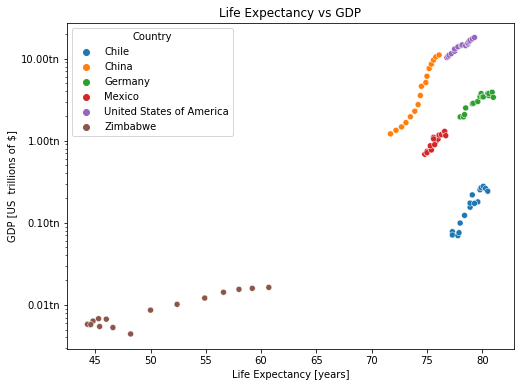

In [14]:
# Scatter plot
plt.figure(figsize=[8, 6])
sns.scatterplot(data=le_df, y='GDP', x='Life_Exp', hue='Country')
plt.yscale('log')
plt.title('Life Expectancy vs GDP')
plt.xlabel('Life Expectancy [years]')
plt.ylabel('GDP [US  trillions of $]')
# Use trillions on y-axis
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}tn'.format(x * 1e-12))

plt.show()

In [23]:
# It seems that GDP is a factor in better life expectancy, but there are surely other factors influencing the data. 

# In Germany's case, it has a similar life expectancy to Chile, even though Germany's GDP is much larger (nearly 10 times)
# than Chile's GDP
# China's life expectancy is about 10 or more years lower than Chile, year on year, but their GDP is ten times as much as Chile's GDP
# These facts place some major doubt on a strong correlation between GDP and Life Expectancy, further strengthening the case 
# for a moderate correlation between GDP and Life Expectancy

# Zimbabwe is an outlier when compared to the other countries as there were catastrophic influences on the life expectancy as well 
# as the GDP during this time frame (2000 - 2015) (Civil War)

In [22]:
# Is there enough evidence to show that nations with higher GDP have higher life expectancy?
# I want to show the 2 sample t-test to see

# NULL HYPOTHESIS: nations with higher GDP do not have a greater life expectancy
# ALTERNATE HYPOTHESIS: nations with higher GDP have a greater life expectancy

# the test compares three countries with high GDP
# high_gdp: China, Germany, USA
# the test compares two countries with low GDP
# low_gdp: Chile, Mexico

# We continue to omit Zimbabwe because its economy and healthcare were adversely affected by the civil war during this period
# We would introduce bias into this study if we included Zimbabwe's data.

# To avoid some the effects to the data over time, we will only include the data from 2015

In [15]:
# Divide country by GDP groups
high_GDP = ['United States of America', 'China', 'Germany']
low_GDP = ['Mexico', 'Chile']
high_GDP_df = le_df[(le_df.Country.isin(high_GDP)) & (le_df.Year == 2015)].reset_index(drop=True).copy()
low_GDP_df = le_df[(le_df.Country.isin(low_GDP)) & (le_df.Year == 2015)].reset_index(drop=True).copy()

# Convert GDP to trillions
high_GDP_df['GDP in trillions'] = ['${:.1f}tn'.format(x/10**12) for x in high_GDP_df['GDP']]
low_GDP_df['GDP in trillions'] = ['${:.1f}tn'.format(x/10**12) for x in low_GDP_df['GDP']]

# Print tables
display(high_GDP_df.style
        .format(df_format)
        .hide_columns(df_hidden_col)
        .set_caption('High GDP')
        .set_properties(width=df_width))
display(low_GDP_df.style
        .format(df_format)
        .hide_columns(df_hidden_col)
        .set_caption('Low GDP')
        .set_properties(width=df_width))

# Two sample t-test
alfa = 0.05
t_stat, p_val = ttest_ind(high_GDP_df.Life_Exp, low_GDP_df.Life_Exp)
result = ('significant:\nnations with an higher GDP have an higher life expectancy.' 
          if (p_val/2 < alfa) & (t_stat > 0) else 
          'not significant:\nthere is no evidence that nations with an higher GDP have an higher life expectancy.')

print(f'\n2-sample t-test is {result}\n')
print(f'Significance level: {alfa}')
print(f'p-value: {p_val:.2e}')
print(f't-statistic: {t_stat:.2f}')

,Country,Year,Life_Exp,GDP in trillions
0,China,2015,76.1,$11.1tn
1,Germany,2015,81.0,$3.4tn
2,United States of America,2015,79.3,$18.1tn


,Country,Year,Life_Exp,GDP in trillions
0,Chile,2015,80.5,$0.2tn
1,Mexico,2015,76.7,$1.2tn



2-sample t-test is not significant:
there is no evidence that nations with an higher GDP have an higher life expectancy.

Significance level: 0.05
p-value: 9.37e-01
t-statistic: 0.09


In [21]:
# The ALTERNATIVE HYPOTHESIS is rejected because the 2-sample t-test is not significant.
# Creating a box plot of the two data sets (high_gdp and low_gdp) further confirms the results of the t-test (still in 2015 only)

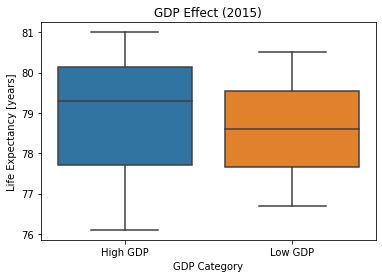

In [16]:
# Aggregate dataframes
wealth_df = pd.concat([high_GDP_df, low_GDP_df])
wealth_df['GDP_Cat'] = None
wealth_df.loc[wealth_df.Country.isin(high_GDP), 'GDP_Cat'] = 'High GDP'
wealth_df.loc[wealth_df.Country.isin(low_GDP), 'GDP_Cat'] = 'Low GDP'

# Boxplot
sns.boxplot(data=wealth_df, x='GDP_Cat', y='Life_Exp')
plt.title('GDP Effect (2015)')
plt.xlabel('GDP Category')
plt.ylabel('Life Expectancy [years]')
plt.show()

In [20]:
# Notice the whiskers of the higher GDP countries are much longer than those of the lower GDP countries. This may have something
# to do with China's much lower life expectancy and Germany's much higher life expectancy. 

In [25]:
# In conclusion, The GDP is only related to the wealth generated by the economy of the country.  
# But, it is not always a direct influence on the life expectancy of the people.

# There are many factors that can detract from a countries GDP, that have no affect on the life expectancy 
# of the people of that country. 
# For example: poor economic policy lowers GDP, but the country has great medical care improves life expectancy
# An additional example: the country could have a great economic policy that improves GDP, but do not focus greatly on citizen's 
# health or well being, which drastically reduces life expectancy

# While the GDP and the Life Expectancy of a country do seem to be correlated, there is a lot more influecing the life expectancy
# of a country's citizens than the country's GDP. A country's level of medical care for its citizens may be improved by a larger 
# GDP, but the GDP likely has little to do with the country's citizens' ability to get or receive medical care. 